In [44]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Create Memory classes

In [33]:
from pydantic import BaseModel, Field
from typing import List

class Memory(BaseModel):
    content: str = Field(..., description="The main content of the memory. User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: List[Memory] = Field(..., description="A list of memories about the user.")


### Listener with Trustcall

To extract thr tool calls made by trustcall under the hood

In [69]:
from trustcall import create_extractor

class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        q=[run]
        while q:
            r=q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(r.outputs["generations"][0]["message"]["kwargs"]["tool_calls"])
        

trustcall_extractor = create_extractor(
    llm, 
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

spy = Spy()

trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)



In [70]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

instruction = """ Extract memories from the following conversations: """

conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

result = trustcall_extractor.invoke({"messages" : [SystemMessage(content=instruction)] + conversation})

In [71]:
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_133JgVaXHpPb0xqUkSKn4WMU', 'function': {'arguments': '{"content":"Lance had a nice bike ride in San Francisco this morning."}', 'name': 'Memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 106, 'total_tokens': 124, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-44a64dab-9aca-496b-8ac2-beaeea7ae4d8-0', tool_calls=[{'name': 'Memory', 'args': {'content': 'Lance had a nice bike ride in San Francisco this morning.'}, 'id': 'call_133JgVaXHpPb0xqUkSKn4WMU', 'type': 'tool_call'}], usage_metadata={'input_tokens': 106, 'output_tokens': 18, 'total_tokens': 

In [72]:
for message in result["messages"]:
    message.pretty_print()



================================== Ai Message ==================================
Tool Calls:
  Memory (call_133JgVaXHpPb0xqUkSKn4WMU)
 Call ID: call_133JgVaXHpPb0xqUkSKn4WMU
  Args:
    content: Lance had a nice bike ride in San Francisco this morning.


In [73]:
for response in result["responses"]:
    print(response.model_dump())


{'content': 'Lance had a nice bike ride in San Francisco this morning.'}


In [74]:
for response_meta in result["response_metadata"]:
    print(response_meta)

{'id': 'call_133JgVaXHpPb0xqUkSKn4WMU'}


In [75]:
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

instruction = """ Update existing memories or create new ones based on the following conversation: """

tool_name = "Memory"
existing_memories = [(str(i) , tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None


print("existing_memories: ", existing_memories)

messages = [SystemMessage(content=instruction)] + updated_conversation

print("messages: ", messages)

result = trustcall_extractor_see_all_tool_calls.invoke({"messages" : messages, "existing" : existing_memories})

print("result: ", result)

existing_memories:  [('0', 'Memory', {'content': 'Lance had a nice bike ride in San Francisco this morning.'})]
messages:  [SystemMessage(content=' Update existing memories or create new ones based on the following conversation: ', additional_kwargs={}, response_metadata={}), AIMessage(content="That's great, did you do after?", additional_kwargs={}, response_metadata={}), HumanMessage(content='I went to Tartine and ate a croissant.', additional_kwargs={}, response_metadata={}), AIMessage(content='What else is on your mind?', additional_kwargs={}, response_metadata={}), HumanMessage(content='I was thinking about my Japan, and going back this winter!', additional_kwargs={}, response_metadata={})]
result:  {'messages': [AIMessage(content='', additional_kwargs={'updated_docs': {'call_8kif2WrGPyD7VwZLfCVLuEae': '0'}}, response_metadata={}, id='dc0e922b-024e-41f4-9e2f-b60610c5e574', tool_calls=[{'name': 'Memory', 'args': {'content': 'Lance had a nice bike ride in San Francisco this morning, 

In [76]:
result

{'messages': [AIMessage(content='', additional_kwargs={'updated_docs': {'call_8kif2WrGPyD7VwZLfCVLuEae': '0'}}, response_metadata={}, id='dc0e922b-024e-41f4-9e2f-b60610c5e574', tool_calls=[{'name': 'Memory', 'args': {'content': 'Lance had a nice bike ride in San Francisco this morning, went to Tartine and ate a croissant.'}, 'id': 'call_8kif2WrGPyD7VwZLfCVLuEae', 'type': 'tool_call'}, {'name': 'Memory', 'args': {'content': 'Lance is thinking about going back to Japan this winter.'}, 'id': 'call_n5ycN1xMyBWRkWL8sErVJHpA', 'type': 'tool_call'}])],
 'responses': [Memory(content='Lance had a nice bike ride in San Francisco this morning, went to Tartine and ate a croissant.'),
  Memory(content='Lance is thinking about going back to Japan this winter.')],
 'response_metadata': [{'id': 'call_8kif2WrGPyD7VwZLfCVLuEae',
   'json_doc_id': '0'},
  {'id': 'call_n5ycN1xMyBWRkWL8sErVJHpA'}],
 'attempts': 1}

In [77]:
for message in result["messages"]:
    message.pretty_print()



================================== Ai Message ==================================
Tool Calls:
  Memory (call_8kif2WrGPyD7VwZLfCVLuEae)
 Call ID: call_8kif2WrGPyD7VwZLfCVLuEae
  Args:
    content: Lance had a nice bike ride in San Francisco this morning, went to Tartine and ate a croissant.
  Memory (call_n5ycN1xMyBWRkWL8sErVJHpA)
 Call ID: call_n5ycN1xMyBWRkWL8sErVJHpA
  Args:
    content: Lance is thinking about going back to Japan this winter.


In [78]:

for response in result["responses"]:
    print(response.model_dump())


{'content': 'Lance had a nice bike ride in San Francisco this morning, went to Tartine and ate a croissant.'}
{'content': 'Lance is thinking about going back to Japan this winter.'}


In [79]:

for response_meta in result["response_metadata"]:
    print(response_meta)

{'id': 'call_8kif2WrGPyD7VwZLfCVLuEae', 'json_doc_id': '0'}
{'id': 'call_n5ycN1xMyBWRkWL8sErVJHpA'}


In [80]:
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': 'Update memory to include visit to Tartine and eating a croissant.',
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'Lance had a nice bike ride in San Francisco this morning, went to Tartine and ate a croissant.'}]},
   'id': 'call_8kif2WrGPyD7VwZLfCVLuEae',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'Lance is thinking about going back to Japan this winter.'},
   'id': 'call_n5ycN1xMyBWRkWL8sErVJHpA',
   'type': 'tool_call'}]]

In [212]:
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )  



def extract_changes(tool_calls, schema_name):
    changes = []

    for call_group in spy.called_tools:
        for call in call_group:
            if call["name"] == "PatchDoc":
                changes.append(
                    f"Type: Update\n"
                    f"Document {call["args"]["json_doc_id"]}\n"
                    f"Updates : {call["args"]["planned_edits"]}\n"
                    f"Updated Content: {call["args"]["patches"][0]["value"]}\n"
                )
            elif call["name"] == "Memory":
                changes.append(
                    f"Type: Create\n"
                    f"New Content: {call['args']}\n"
                )
    result = "\n".join(changes)
    return result




In [213]:
from typing import TypedDict, Literal

class UpdateMemory(TypedDict):
    """ Decision on what memory type to update"""
    update_type : Literal["user", "todo", "instructions"]

In [214]:
import uuid
from IPython.display import display, Image
from datetime import datetime
from trustcall import create_extractor
from typing import TypedDict, Literal, Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

class Profile(BaseModel):
    """ This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(None, description="The name of the user you are chatting with")
    location: Optional[str] = Field(None, description="The location of the user you are chatting with")
    job: Optional[str] = Field(None, description="The job of the user you are chatting with")
    connections: List[str] = Field( description="The connections of the user you are chatting with", default_factory=list)
    interests: List[str] = Field( description="The interests of the user you are chatting with", default_factory=list)

class ToDo(BaseModel):
    """ This is the to do list of the user you are chatting with"""
    task: str = Field(description="The task need to be completed")
    time_to_complete: Optional[int] = Field(descrption="Estimate time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(description="Whn the task needs to be completed (if applicable)", default =None)
    solution: List[str] = Field(description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)", min_items=1, default_factory=list)
    status: Literal["not_started", " in_progress", "done", "archieved"] = Field(description="The current status of the task", default="not_started")

class Instructions(BaseModel):
    """ This is the instructions for the user you are chatting with"""
    instructions: str = Field(description="The instructions for the user you are chatting with")


In [215]:
class TaskMasterState(MessagesState):
    profile: List[Profile] = Field(description="The user's profile", default_factory=list)
    todo: List[ToDo] = Field(description="The user's todo list", default_factory=list)
    instructions: List[Instructions] = Field(description="The user's instructions", default_factory=list)


In [232]:
def task_master(state: TaskMasterState, config: RunnableConfig, store: BaseStore):

    """ Load meories from the store and use them to personalize th chatbot's experience """

    print("*****************************TASK MASTER NODE*****************************\n")
    print(f"State: {state}\n")
    print("----------------------------------------------------------------------------\n")
    print(f"Config: {config}\n")
    print("----------------------------------------------------------------------------\n")
    
    #Get Profile Memory from the Store
    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "profile")
    memories = store.search(namespace)

    if memories:
        print(f"Existing Profile: {memories}\n")
        print("----------------------------------------------------------------------------\n")
        user_profile = memories[0].value
    else:
        print("No existing profile found.")
        print("----------------------------------------------------------------------------\n")
        user_profile = None

    # Get Task Memory from thr Store
    namespace = (user_id, "todo")
    memories = store.search(namespace)

    if memories:
        todo = "\n".join([f"{i+1}. {memory.value}" for i, memory in enumerate(memories)])
        print(f"Existing Task(s): {todo}\n")
        print("----------------------------------------------------------------------------\n")
    else:
        todo = None
        print("No existing task found.")
        print("----------------------------------------------------------------------------\n")
        

    # Get Instructions Memory from the Store
    namespace = (user_id, "instructions")
    memories = store.search(namespace)
    if memories:
        instructions = "\n".join([f"{i+1}. {memory.value}" for i, memory in enumerate(memories)])
        print(f"Existing Instructions: {instructions}\n")
        print("----------------------------------------------------------------------------\n")
    else:
        print("No existing instructions found.")
        print("----------------------------------------------------------------------------\n")
        instructions = ""


    MODEL_SYSTEM_MESSAGE = """ 
    You are a helpful chatbot.
    You are designed to be a companion to a user, helping them to track their ToDo list.

    You have a long term memory which keeps track of three things:
    1. The user's profile
    2. The user's ToDo list
    3. General instructions for updating the ToDo list

    Here is the current User Profile (may be empty if no information has been collected yet):
    <user_profile>
    {user_profile}
    </user_profile>

    Here is the current ToDo List (may be set if no tasks have been added yet):
    <todo>
    {todo}
    </todo>

    Here are the current user-specified instructions for updating the ToDo list (may be empty if no preferences have been specified yet)
    <instructions>
    {instructions}
    </instructions>

    Here are your instructions for reasoning about the user's messages:

    1. Reason carefully about the user's messages as presented below.

    2. Decide weather any of your long term memories needs to be updated.
        - If the user has provided any new personal information, update the user profile by calling UpdateMemory tool with type "user"
        - If the user has mentioned any task, update the todo list by calling UpdateMemmory tool with type "todo".
        - If the user has specified any preferences for how to update the ToDo List. update the instructions by calling the UpdateMemory tool with type "instructions".

    3. Tell the user that you have updated the memory, if apprepriate:
        - Do not tell the user you have updated user's profile
        - Tell the user you have update the ToDo list
        - Do not tell the user you have updated instructions

    4. Err on the side of updating the todo list. No need to ask for explicit permission.schema_name

    5.Respond naturally to the user's message after a tool call was made to save memories, or if no tool call was made.

    """
    system_message = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)
    
    llm_with_tools = llm.bind_tools([UpdateMemory], parallel_tool_calls=False)

    response = llm_with_tools.invoke([SystemMessage(content=system_message)] + state["messages"])

    print(f"Response: {response}\n")
    print("----------------------------------------------------------------------------\n")

    return {"messages" : [response]}





In [245]:
def route_messages(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[ END , "update_todos", "update_profile", "update_instructions"] :
    """ Route the user's message to the appropriate node """

    message = state["messages"][-1]
    if len(message.tool_calls) == 0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call["args"]["update_type"] == "todo":
            return "update_todos"
        elif tool_call["args"]["update_type"] == "user":
            return "update_profile"
        elif tool_call["args"]["update_type"] == "instructions":
            return "update_instructions"
        else:
            return ValueError


In [296]:
from uuid import uuid4
def update_profile(state: TaskMasterState, config: RunnableConfig, store: BaseStore):
    """ Update the user's profile """

    print("*****************************UPDATE PROFILE NODE*****************************\n")
    print(f"State: {state}\n")
    print("----------------------------------------------------------------------------\n")
    print(f"Config: {config}\n")
    print("----------------------------------------------------------------------------\n")

    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "profile")
    existing_profile_items = store.search(namespace)

    existing_profile = ([(item.key , "Profile", item.value) for item in existing_profile_items] if existing_profile_items else None)

    print(f"Existing Profile: {existing_profile}\n")
    print("----------------------------------------------------------------------------\n")

    TRUSTCALL_INSTRUCTION = """
    Reflect on the following interaction.
    Use the provided tools to retain any necessary memories about the user.
    Use parallel tool calling to handle updates and insertions simultaneously.
    System Time : {time}
    """

    system_message = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())

    spy = Spy()
    
    trustcall_profile_extractor = create_extractor(
        llm,
        tools=[Profile],
        tool_choice="Profile",
        enable_inserts=True,
    ).with_listeners(on_end=spy)

    print(f"Tool Calls: {state['messages'][-1].tool_calls}\n")
    print("----------------------------------------------------------------------------\n")

    messages = [SystemMessage(content=system_message)] + state["messages"][:-1] # To exclude the tool call message

    response = trustcall_profile_extractor.invoke({"messages" : messages, "existing" : existing_profile})

    print(f"Response: {response}\n")
    print("----------------------------------------------------------------------------\n")

    profile = []
    for r_meta, r in zip(response["response_metadata"], response["responses"]):
        print(r_meta.get("json_doc_id", str(uuid4())))
        print("---------------------------------------------------")
        print(r.model_dump())
        print("---------------------------------------------------")
        store.put(namespace, r_meta.get("json_doc_id", str(uuid4())), r.model_dump(mode="json"))
        profile.append(r.model_dump())

    print(f"State Messages: {state['messages']}\n")
    print("---------------------------------------------------\n")
    print(f"Spy called tools: {extract_changes(spy.called_tools, 'Profile')}\n")
    print("---------------------------------------------------\n")
    print("Profile updated:\n")
    print(profile)
    print("---------------------------------------------------\n")

    tool_call_id = state["messages"][-1].tool_calls[0]['id']
    print(f"Tool Call ID: {tool_call_id}\n")
    print("---------------------------------------------------\n")


    return {"messages" : [{"role" : "tool" ,  "content" : "Profile updated", "tool_call_id" : tool_call_id}], "profile" : profile}

    

In [298]:
from uuid import uuid4
def update_todos(state: TaskMasterState, config: RunnableConfig, store: BaseStore):
    """ Update the user's todo list """

    print("*****************************UPDATE TODO NODE*****************************\n")
    print(f"State: {state}\n")
    print("----------------------------------------------------------------------------\n")
    print(f"Config: {config}\n")
    print("----------------------------------------------------------------------------\n")

    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "todo")
    existing_todo_items = store.search(namespace)

    existing_todo = ([(item.key , "ToDo", item.value) for item in existing_todo_items] if existing_todo_items else None)

    print(f"Existing ToDo: {existing_todo}\n")
    print("----------------------------------------------------------------------------\n")

    TRUSTCALL_INSTRUCTION = """
    Reflect on the following interaction.
    Use the provided tools to retain any necessary memories about the user.
    Use parallel tool calling to handle updates and insertions simultaneously.
    System Time : {time}
    """

    system_message = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())

    spy = Spy()

    trustcall_profile_extractor = create_extractor(
        llm,
        tools=[ToDo],
        tool_choice="ToDo",
        enable_inserts=True,
    ).with_listeners(on_end=spy)

    messages = [SystemMessage(content=system_message)] + state["messages"][:-1] # To exclude the tool call message

    print(f"Tool Calls: {state['messages'][-1].tool_calls}\n")
    print("----------------------------------------------------------------------------\n")

    response = trustcall_profile_extractor.invoke({"messages" : messages, "existing" : existing_todo})

    print(f"Response: {response}\n")
    print("----------------------------------------------------------------------------\n")

    todo = []
    for r_meta, r in zip(response["response_metadata"], response["responses"]):
        print(r_meta.get("json_doc_id", str(uuid4())))
        print("---------------------------------------------------")
        print(r.model_dump())
        print("---------------------------------------------------")
        store.put(namespace, r_meta.get("json_doc_id", str(uuid4())), r.model_dump(mode="json"))
        todo.append(r.model_dump())

    print(f"State Messages: {state['messages']}\n")
    print("---------------------------------------------------\n")
    print(f"Spy called tools: {extract_changes(spy.called_tools, 'ToDo')}\n")
    print("---------------------------------------------------\n")
    print("Todo updated:\n")
    print(todo)
    print("---------------------------------------------------\n")

    tool_call_id = state["messages"][-1].tool_calls[0]['id']
    print(f"Tool Call ID: {tool_call_id}\n")
    print("---------------------------------------------------\n")

    return {"messages" : [{"role" : "tool" ,  "content" : "Todo updated", "tool_call_id" : tool_call_id}], "todo" : todo}

    

In [299]:
def update_instructions(state: TaskMasterState, config: RunnableConfig, store: BaseStore):
    """ Update the user's instructions """

    print("*****************************UPDATE INSTRUCTIONS NODE*****************************\n")
    print(f"State: {state}\n")
    print("----------------------------------------------------------------------------\n")
    print(f"Config: {config}\n")
    print("----------------------------------------------------------------------------\n")

    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "instructions")
    existing_instructions = store.search(namespace)

    existing_instructions = ([(item.key , "Instructions", item.value) for item in existing_instructions] if existing_instructions else None)
    print(f"Existing Instructions: {existing_instructions}\n")
    print("----------------------------------------------------------------------------\n")

    CREATE_INSTRUCTIONS = """Reflect on the following interaction.

    Based on this interaction, update your instructions for how to update ToDo list items. 

    Use any feedback from the user to update how they like to have items added, etc.

    Your current instructions are:

    """


    spy = Spy()

    trustcall_instructions_extractor = create_extractor(
        llm,
        tools=[Instructions],
        tool_choice="Instructions",
        enable_inserts=True,
    ).with_listeners(on_end=spy)

    messages = [SystemMessage(content=CREATE_INSTRUCTIONS)] + state["messages"][:-1] # To exclude the tool call message

    response = trustcall_instructions_extractor.invoke({"messages" : messages, "existing" : existing_instructions})

    print(f"Response: {response}\n")
    print("----------------------------------------------------------------------------\n")

    instructions = []
    for r_meta, r in zip(response["response_metadata"], response["responses"]):
        print(r_meta.get("json_doc_id", str(uuid4())))
        print("---------------------------------------------------")
        print(r.model_dump())
        print("---------------------------------------------------")
        store.put(namespace, r_meta.get("json_doc_id", str(uuid4())), r.model_dump(mode="json"))
        instructions.append(r.model_dump())
    print(f"State Messages: {state['messages']}\n")
    print("---------------------------------------------------\n")
    print(f"Spy called tools: {extract_changes(spy.called_tools, 'Instructions')}\n")
    print("---------------------------------------------------\n")
    print("Instructions updated:\n")
    print(instructions)
    print("---------------------------------------------------\n")

    tool_call_id = state["messages"][-1].tool_calls[0]['id']
    print(f"Tool Call ID: {tool_call_id}\n")
    print("---------------------------------------------------\n")

    return {"messages" : [{"role" : "tool" ,  "content" : "Instructions updated", "tool_call_id" : tool_call_id}], "instructions" : instructions}

    

    


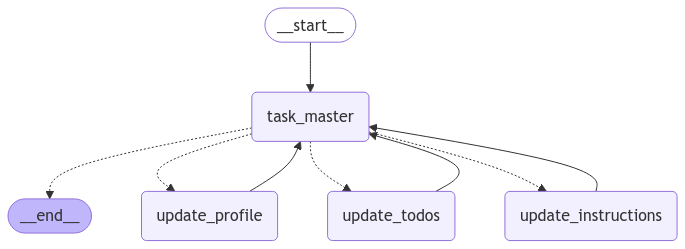

In [300]:
builder = StateGraph(TaskMasterState)

builder.add_node("task_master", task_master)
builder.add_node("update_profile", update_profile)
builder.add_node("update_todos", update_todos)
builder.add_node("update_instructions", update_instructions)

builder.add_edge(START, "task_master")
builder.add_conditional_edges("task_master", route_messages, [END, "update_profile", "update_todos", "update_instructions"])
builder.add_edge("update_profile", "task_master")
builder.add_edge("update_todos", "task_master")
builder.add_edge("update_instructions", "task_master")

within_thread_memory = MemorySaver()
across_thread_memory = InMemoryStore()



graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))





In [307]:
config = {"configurable": {"thread_id": "10", "user_id": "10"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Lance. I live in SF with my wife. I have a 1 year old daughter.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='My name is Lance. I live in SF with my wife. I have a 1 year old daughter.', additional_kwargs={}, response_metadata={}, id='807cfc8c-c664-4f83-a606-8fd93dd6e7d2')]}
*****************************TASK MASTER NODE*****************************

State: {'messages': [HumanMessage(content='My name is Lance. I live in SF with my wife. I have a 1 year old daughter.', additional_kwargs={}, response_metadata={}, id='807cfc8c-c664-4f83-a606-8fd93dd6e7d2')]}

----------------------------------------------------------------------------

Config: {'metadata': {'thread_id': '10', 'user_id': '10', 'langgraph_step': 1, 'langgraph_node': 'task_master', 'langgraph_triggers': ['start:task_master'], 'langgraph_path': ('__pregel_pull', 'task_master'), 'langgraph_checkpoint_ns': 'task_master:0c1fc18c-6384-6623-3b54-4cb1456e0df9'}, 'configurable': {'thread_id': '10', 'user_id': '10', '__pregel_resuming': False, '__pregel_task_id': '0c1fc18c-6384-6623-3b54-4cb1456e0df9', '__p

In [308]:
config = {"configurable": {"thread_id": "10", "user_id": "10"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My wife asked me to book swim lessons for the baby.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='My name is Lance. I live in SF with my wife. I have a 1 year old daughter.', additional_kwargs={}, response_metadata={}, id='807cfc8c-c664-4f83-a606-8fd93dd6e7d2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T1hRrcnPA5o8zHTcgU4Uzxt5', 'function': {'arguments': '{"update_type":"user"}', 'name': 'UpdateMemory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 488, 'total_tokens': 504, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f2cd28694a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b63b24f1-8576-4c59-91b4-5181460ae7ae-0', tool_calls=[{'name': 'UpdateMemory', 'args': {'update_type': 'user'}, 'id': 'call_T1hRrcnPA5o8zHTcg

In [309]:
config = {"configurable": {"thread_id": "10", "user_id": "10"}}

input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
*****************************TASK MASTER NODE*****************************

State: {'messages': [HumanMessage(content='My name is Lance. I live in SF with my wife. I have a 1 year old daughter.', additional_kwargs={}, response_metadata={}, id='807cfc8c-c664-4f83-a606-8fd93dd6e7d2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T1hRrcnPA5o8zHTcgU4Uzxt5', 'function': {'arguments': '{"update_type":"user"}', 'name': 'UpdateMemory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 488, 'total_tokens': 504, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-20

In [291]:
state = graph.get_state(config)


In [311]:
from pprint import pprint
user_id = config["configurable"]["user_id"]
namespace = (user_id, "profile")
memories = across_thread_memory.search(namespace)
for memory in memories:
    pprint(memory.value)


{'connections': ['wife', '1 year old daughter'],
 'interests': [],
 'job': None,
 'location': 'SF',
 'name': 'Lance'}


In [319]:

user_id = config["configurable"]["user_id"]
namespace = (user_id, "todo")
memories = across_thread_memory.search(namespace)
for memory in memories:
    pprint(memory.value)

{'deadline': '2025-11-30T23:59:59Z',
 'solution': ['Research local swim schools',
              'Contact swim schools for availability',
              'Book a class'],
 'status': 'not_started',
 'task': 'Book swim lessons for the baby',
 'time_to_complete': 60}
{'deadline': '2025-11-30T23:59:59Z',
 'solution': ['Inspect the lock mechanism',
              'Lubricate the lock',
              'Check for any obstructions'],
 'status': 'not_started',
 'task': 'Fix the jammed electric Yale lock on the door',
 'time_to_complete': 30}
{'deadline': None,
 'solution': ['Look up locksmiths in SF', 'Read reviews', 'Contact for quotes'],
 'status': 'not_started',
 'task': 'Research local locksmiths for assistance with the Yale lock',
 'time_to_complete': 30}
{'deadline': None,
 'solution': ['Find the contact number for City Toyota',
              'Prepare details about the car service needed',
              'Call City Toyota to schedule an appointment'],
 'status': 'not_started',
 'task': 'Call bac

In [313]:

user_id = config["configurable"]["user_id"]
namespace = (user_id, "instructions")
memories = across_thread_memory.search(namespace)
for memory in memories:
    pprint(memory.value)

{'instructions': 'When creating or updating ToDo items, include specific local '
                 'businesses or vendors relevant to the task.'}


In [310]:
config = {"configurable": {"thread_id": "10", "user_id": "10"}}

input_messages = [HumanMessage(content="I need to fix the jammed electric Yale lock on the door.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the jammed electric Yale lock on the door.
*****************************TASK MASTER NODE*****************************

State: {'messages': [HumanMessage(content='My name is Lance. I live in SF with my wife. I have a 1 year old daughter.', additional_kwargs={}, response_metadata={}, id='807cfc8c-c664-4f83-a606-8fd93dd6e7d2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T1hRrcnPA5o8zHTcgU4Uzxt5', 'function': {'arguments': '{"update_type":"user"}', 'name': 'UpdateMemory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 488, 'total_tokens': 504, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerp

In [314]:
config = {"configurable": {"thread_id": "10", "user_id": "10"}}


input_messages = [HumanMessage(content="For the swim lessons, I need to get that done by end of November.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the swim lessons, I need to get that done by end of November.
*****************************TASK MASTER NODE*****************************

State: {'messages': [HumanMessage(content='My name is Lance. I live in SF with my wife. I have a 1 year old daughter.', additional_kwargs={}, response_metadata={}, id='807cfc8c-c664-4f83-a606-8fd93dd6e7d2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T1hRrcnPA5o8zHTcgU4Uzxt5', 'function': {'arguments': '{"update_type":"user"}', 'name': 'UpdateMemory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 488, 'total_tokens': 504, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'syste

In [316]:
# User input for a ToDo
input_messages = [HumanMessage(content="Need to call back City Toyota to schedule car service.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back City Toyota to schedule car service.
*****************************TASK MASTER NODE*****************************

State: {'messages': [HumanMessage(content='My name is Lance. I live in SF with my wife. I have a 1 year old daughter.', additional_kwargs={}, response_metadata={}, id='807cfc8c-c664-4f83-a606-8fd93dd6e7d2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T1hRrcnPA5o8zHTcgU4Uzxt5', 'function': {'arguments': '{"update_type":"user"}', 'name': 'UpdateMemory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 488, 'total_tokens': 504, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerpri

In [317]:
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
*****************************TASK MASTER NODE*****************************

State: {'messages': [HumanMessage(content='My name is Lance. I live in SF with my wife. I have a 1 year old daughter.', additional_kwargs={}, response_metadata={}, id='807cfc8c-c664-4f83-a606-8fd93dd6e7d2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T1hRrcnPA5o8zHTcgU4Uzxt5', 'function': {'arguments': '{"update_type":"user"}', 'name': 'UpdateMemory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 488, 'total_tokens': 504, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_

In [318]:
input_messages = [HumanMessage(content="Yes, give me some options to call for swim lessons.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for swim lessons.
*****************************TASK MASTER NODE*****************************

State: {'messages': [HumanMessage(content='My name is Lance. I live in SF with my wife. I have a 1 year old daughter.', additional_kwargs={}, response_metadata={}, id='807cfc8c-c664-4f83-a606-8fd93dd6e7d2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T1hRrcnPA5o8zHTcgU4Uzxt5', 'function': {'arguments': '{"update_type":"user"}', 'name': 'UpdateMemory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 488, 'total_tokens': 504, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint'